Import all necessary modules and check GPU.

In [4]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pydot
from tensorflow.keras.utils import plot_model
import pc  # custom module

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Check CUDA support
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("CUDA enabled.")
else:
    print("CUDA not enabled.")

# Enable automatic mixed precision (not compatible with my GPU GeForce GTX 1060 6GB)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA not enabled.


Set folder with dataset, number of epochs, batch size, resolution and seed.

In [5]:
# Path to dataset
data_folder = "/app/data/PokemonData"
# Training parameters
EP = 100
BS = 32
# Image resolution
RES = (224, 224)
# Random seed
SEED = 42

Create dataset with specified parameters.

In [6]:
data_dict = pc.create_dataset(
    data_folder,
    epochs=EP,
    batch_size=BS,
    res=RES,
    seed=SEED,
)

Split dataset into train, validation and test set.

In [7]:
train_dataset = data_dict["train_dataset"]
val_dataset = data_dict["val_dataset"]
test_dataset = data_dict["test_dataset"]
label_encoder = data_dict["label_encoder"]

Get length of train, validation and test set. Print them.

In [8]:
train_len = data_dict["train_len"]
val_len = data_dict["val_len"]
test_len = data_dict["test_len"]
# print(list(label_encoder.classes_))
# np.save('classes.npy', label_encoder.classes_)
print(f"Number of training samples: {train_len}")
print(f"Number of validation samples: {val_len}")
print(f"Number of test samples: {test_len}")

Number of training samples: 9689
Number of validation samples: 1127
Number of test samples: 1127


Associate image to label encoder. Show 8 samples from train set.

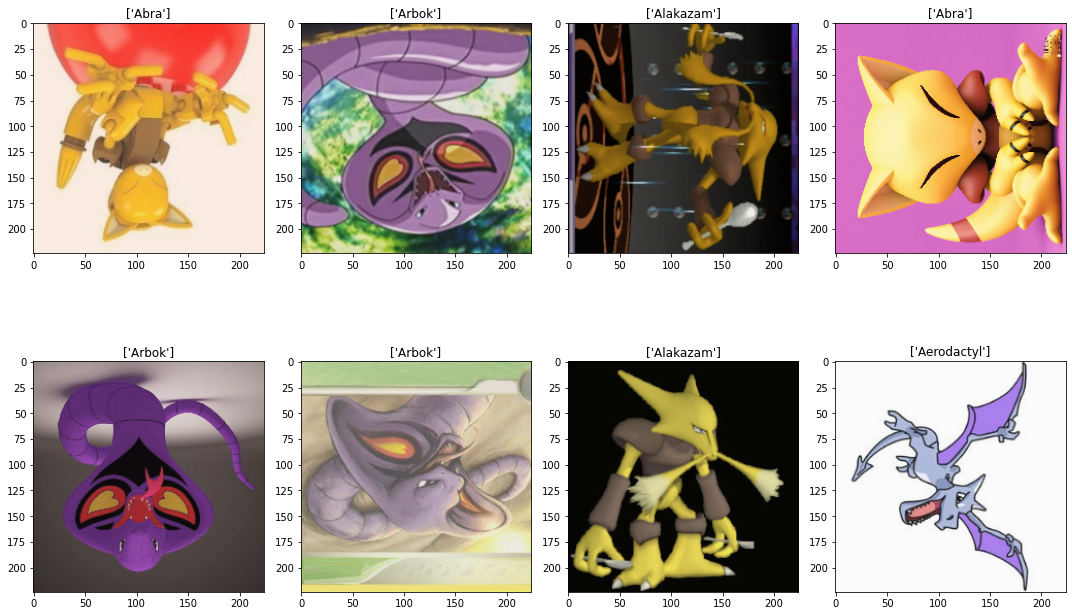

In [9]:
plt.figure(figsize=(15, 10))

# Iterate over batches
for (image_batch, label_batch) in train_dataset:
    # Iterate over elements in batch
    for i, (image, label) in enumerate(zip(image_batch[:8], label_batch[:8])):
        plt.subplot(2, 4, i + 1)
        plt.title(label_encoder.inverse_transform([label]))
        plt.imshow((255 * image.numpy()).astype(np.uint8))
    break

plt.tight_layout()
plt.show()

ResNet with some specs I'll modify later.

In [10]:
model = pc.resnet(input_shape=(224, 224, 3), n_stages=3)

Compile model with specified optimizer (and change learning rate and so on pls)

In [11]:
# Da cambiare assolutamente questa parte
#opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.Adam()#learning_rate=0.01

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # from_logits=True: output is not normalized, softmax function will be automatically applied
    metrics=['accuracy']
)

Fit model with `EarlyStopping` and `patience = 10`, and get the best model before the last worst 10 epochs. Monitor validation loss.

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EP,
    callbacks=[callback],
    steps_per_epoch=train_len // BS,
    validation_data=val_dataset,
    validation_steps=val_len // BS
)

Epoch 1/100
302/302 [==============================] - 163s 537ms/step - loss: 4.8308 - accuracy: 0.0713 - val_loss: 5.0562 - val_accuracy: 0.0143
Epoch 2/100
302/302 [==============================] - 162s 537ms/step - loss: 4.4815 - accuracy: 0.0682 - val_loss: 5.0224 - val_accuracy: 0.0152
Epoch 3/100
302/302 [==============================] - 162s 536ms/step - loss: 3.9624 - accuracy: 0.0988 - val_loss: 5.2298 - val_accuracy: 0.0134
Epoch 4/100
302/302 [==============================] - 162s 537ms/step - loss: 3.5789 - accuracy: 0.1318 - val_loss: 5.5232 - val_accuracy: 0.0330
Epoch 5/100
302/302 [==============================] - 162s 538ms/step - loss: 3.3991 - accuracy: 0.1508 - val_loss: 5.4031 - val_accuracy: 0.0232
Epoch 6/100
302/302 [==============================] - 162s 538ms/step - loss: 3.2760 - accuracy: 0.1641 - val_loss: 5.4560 - val_accuracy: 0.0214
Epoch 7/100
302/302 [==============================] - 162s 536ms/step - loss: 3.2079 - accuracy: 0.1708 - val_loss: 5

KeyboardInterrupt: 

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(151)(x)
outputs = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.trainable=True
opt2 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
model.compile(
    optimizer=opt2,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # from_logits=True: output is not normalized, softmax function will be automatically applied
    metrics=['accuracy']
)
history = model.fit(
    train_dataset,
    epochs=EP,
    callbacks=[callback],
    steps_per_epoch=train_len // BS,
    validation_data=val_dataset,
    validation_steps=val_len // BS
)

Save model (Tensorflow standard format)

In [ ]:
# Save model (tensorflow standard format)
model.save("new_model_no_bright_contrast")

Get all train, validation, and test labels. Plot 3 graphs with the number of each Pokémon for train, validation and test set.

In [ ]:
train_labels = {
    label_encoder.inverse_transform([i])[0]: 0
    for i in range(151)
}
train_it = iter(train_dataset)
for i in range(train_len // BS):
    (_, label_batch) = next(train_it)
    for label in label_batch:
        label_name = label_encoder.inverse_transform([label])[0]
        train_labels[label_name] += 1
print("Training: done")

val_labels = {
    label_encoder.inverse_transform([i])[0]: 0
    for i in range(151)
}
val_it = iter(val_dataset)
for i in range(val_len // BS):
    (_, label_batch) = next(val_it)
    for label in label_batch:
        label_name = label_encoder.inverse_transform([label])[0]
        val_labels[label_name] += 1
print("Validation: done")
        
#val_labels = [0 for _ in range(151)]
#val_it = iter(val_dataset)
#for i in range(val_len // BS):
#    (_, label_batch) = next(val_it)
#    for label in label_batch:
#        val_labels[label.numpy()] +=1
#print("Validation: done")

test_labels = {
    label_encoder.inverse_transform([i])[0]: 0
    for i in range(151)
}
#test_labels = [0 for _ in range(151)]
test_it = iter(test_dataset)
for i, (_, label) in enumerate(test_it):
    label_name = label_encoder.inverse_transform([label])[0]
    test_labels[label_name] += 1
    #test_labels[label.numpy()[0]]+=1
print("Test: done")

plt.figure(figsize=(10, 40))

plt.title("Training classes")
plt.barh(list(train_labels.keys()), train_labels.values())

plt.figure(figsize=(10, 40))
plt.title("Validation classes")
plt.barh(list(val_labels.keys()), val_labels.values())

plt.figure(figsize=(10, 40))
plt.title("Test classes")
plt.barh(list(test_labels.keys()), test_labels.values())
plt.show()

# plt.figure(figsize=(15, 10))
# plt.subplot(3, 1, 1)
# plt.plot(train_labels)
# plt.title("Training classes")
# plt.subplot(3, 1, 2)
# plt.plot(val_labels)
# plt.title("Validation classes")
# plt.subplot(3, 1, 3)
# plt.plot(test_labels)
# plt.title("Test classes")
# plt.tight_layout()
# plt.show()


Test model with test set.

In [ ]:
test_dict = model.evaluate(
    test_dataset,
    steps=test_len,
    return_dict=True
)

Plot train, validation loss and accuracy.

In [ ]:
plt.figure(figsize=(15, 5))  # set graph dimension

# 1. First graph

plt.subplot(1, 2, 1)  # creates 1 subplot out of 2

plt.title("Training and validation loss")
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.grid()

# 2. Second Graph

plt.subplot(1, 2, 2)  # creates 1 subplot out of 2

plt.title("Training and validation accuracy")
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

Convert keras model to tflite model and save it.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_name.tflite', 'wb') as f:
    f.write(tflite_model)

Model quantization on tflite model.

In [ ]:
#model = tf.keras.models.load_model("./model_best_100")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()#save converted quantization model to tflite format
open("resnet_model_qa_8bit.tflite", "wb").write(tflite_quant_model)

In [ ]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_tensor=tf.keras.Input(shape=(224, 224, 3)),
    pooling='avg', classes=151
)
# model.trainable=False
model.summary()
plot_model(model, show_shapes=True)